In [43]:
import numpy as np
import matplotlib.pyplot as plt

from scipy.spatial.distance import cdist

from numpy.linalg import inv
from numpy.linalg import det
from numpy.linalg import eig

import tensorflow as tf
import tensorflow_probability as tfp

import gpflow



In [44]:
def cholesky_with_jitter(K, jitter):
    k_diag = tf.linalg.diag_part(K)
    jitter_diag = tf.fill(tf.shape(k_diag), tf.cast(jitter, dtype=K.dtype))
    jittered_K = tf.linalg.set_diag(K, k_diag + jitter_diag)
    return tf.linalg.cholesky(jittered_K)

K1 = gpflow.kernels.SquaredExponential(variance=1, lengthscales=5)
K2 = gpflow.kernels.SquaredExponential(variance=1, lengthscales=10)

pi = tf.cast(np.pi, tf.float64)

noise = tf.cast(1, tf.float64)

In [45]:
N = 100
M = 30

In [46]:
Xs = np.linspace(1, 10, 100).reshape(-1,1)
X = np.random.uniform(1, 10, N).reshape(-1,1)
Y = 10*tf.math.sin((X))

Z1 = X[0:M]
Z2 = X[0:M]

In [47]:
m1 = tf.Variable(np.zeros(M).reshape(-1,1))
S1 = tf.Variable(np.identity(M))
m2 = tf.Variable(np.zeros(M).reshape(-1,1))
S2 = tf.Variable(np.identity(M))

In [48]:
def elbo(m1,S1,m2,S2):
    
    inv_K_Z1Z1 = inv(  cholesky_with_jitter(K1(Z1,Z1),1e-10)@tf.transpose(cholesky_with_jitter(K1(Z1,Z1),1e-10)))
    f1_sample_list = []

    for i in range (0,N):
        f1_sample_mean = tf.linalg.matmul(tf.linalg.matmul(K1(X[i].reshape(-1,1),Z1),inv_K_Z1Z1),m1)
        f1_sample_covariance = K1(X[i].reshape(-1,1),X[i].reshape(-1,1))-tf.linalg.matmul(tf.linalg.matmul(K1(X[i].reshape(-1,1),Z1),inv_K_Z1Z1),K1(Z1,X[i].reshape(-1,1)))+tf.linalg.matmul(tf.linalg.matmul(tf.linalg.matmul(tf.linalg.matmul(K1(X[i].reshape(-1,1),Z1),inv_K_Z1Z1),S1@tf.transpose(S1)),inv_K_Z1Z1),K1(Z1,X[i].reshape(-1,1)))
        f1_sample = tf.math.reduce_mean(tfp.distributions.Normal(f1_sample_mean,f1_sample_covariance).sample(100))
        f1_sample_list.append(f1_sample)
    
    
    f1_sample_list = np.array(f1_sample_list).reshape(-1,1)
   
    inv_K_Z2Z2 = inv(  cholesky_with_jitter(K2(Z2,Z2),1e-10)@tf.transpose(cholesky_with_jitter(K2(Z2,Z2),1e-10)))


    
    likelihood_GP = tf.cast(0,tf.float64)
        
    for i in range (0,N):
        
        f2_sample_mean = tf.linalg.matmul(tf.linalg.matmul(K2(f1_sample_list[i].reshape(-1,1),Z2),inv_K_Z2Z2),m2)
        f2_sample_covariance = K2(f1_sample_list[i].reshape(-1,1),f1_sample_list[i].reshape(-1,1))-tf.linalg.matmul(tf.linalg.matmul(K2(f1_sample_list[i].reshape(-1,1),Z2),inv_K_Z2Z2),K2(Z2,f1_sample_list[i].reshape(-1,1)))+tf.linalg.matmul(tf.linalg.matmul(tf.linalg.matmul(tf.linalg.matmul(K2(f1_sample_list[i].reshape(-1,1),Z2),inv_K_Z2Z2),S2@tf.transpose(S2)),inv_K_Z2Z2),K2(Z2,f1_sample_list[i].reshape(-1,1)))
        f2_sample = tf.math.reduce_mean(tfp.distributions.Normal(f2_sample_mean,f2_sample_covariance).sample(100))
        
        likelihood =tf.math.multiply(tf.cast(-1/2,tf.float64),tf.math.log(tf.math.multiply(tf.cast(2,tf.float64),tf.math.multiply(pi,tf.math.square(noise))))) - tf.math.divide(tf.math.square((Y[i]-f2_sample)),tf.math.square(noise))
        likelihood_GP = likelihood_GP + likelihood
      
   
    KL1 = tf.math.multiply(tf.cast(-1/2,tf.float64),(tf.linalg.trace(tf.linalg.matmul(inv_K_Z1Z1,S1@tf.transpose(S1)))+tf.linalg.matmul(tf.linalg.matmul(tf.transpose(m1),inv_K_Z1Z1),m1)-M+tf.math.log(tf.linalg.det(cholesky_with_jitter(K1(Z1,Z1),1e-5)))-tf.math.log(tf.linalg.det(S1@tf.transpose(S1)))))
    KL2 = tf.math.multiply(tf.cast(-1/2,tf.float64),(tf.linalg.trace(tf.linalg.matmul(inv_K_Z2Z2,S2@tf.transpose(S2)))+tf.linalg.matmul(tf.linalg.matmul(tf.transpose(m2),inv_K_Z2Z2),m2)-M+tf.math.log(tf.linalg.det(cholesky_with_jitter(K2(Z2,Z2),1e-5)))-tf.math.log(tf.linalg.det(S2@tf.transpose(S2)))))
    
    KL_GP = KL1+KL2
    
    elbo = (likelihood_GP - KL_GP)



    return elbo

In [49]:
optimizer = tf.keras.optimizers.Adam(learning_rate = 0.5)
for i in range(500):
    with tf.GradientTape() as tape:
        objective = elbo(m1,S1,m2,S2)
        gradients = tape.gradient(objective, [m1,S1,m2,S2])
    print(i, "objective:", objective)
    optimizer.apply_gradients(zip(gradients, [m1,S1,m2,S2]))

0 objective: tf.Tensor([[2.19401211e+11]], shape=(1, 1), dtype=float64)
1 objective: tf.Tensor([[nan]], shape=(1, 1), dtype=float64)
2 objective: tf.Tensor([[3.7805258e+11]], shape=(1, 1), dtype=float64)
3 objective: tf.Tensor([[6.83924375e+11]], shape=(1, 1), dtype=float64)
4 objective: tf.Tensor([[8.46183836e+11]], shape=(1, 1), dtype=float64)
5 objective: tf.Tensor([[8.04118665e+11]], shape=(1, 1), dtype=float64)
6 objective: tf.Tensor([[7.98293033e+11]], shape=(1, 1), dtype=float64)
7 objective: tf.Tensor([[8.89563279e+11]], shape=(1, 1), dtype=float64)
8 objective: tf.Tensor([[9.73920808e+11]], shape=(1, 1), dtype=float64)
9 objective: tf.Tensor([[9.65234195e+11]], shape=(1, 1), dtype=float64)
10 objective: tf.Tensor([[8.83084211e+11]], shape=(1, 1), dtype=float64)
11 objective: tf.Tensor([[-7.06630306e+13]], shape=(1, 1), dtype=float64)
12 objective: tf.Tensor([[5.83846013e+11]], shape=(1, 1), dtype=float64)
13 objective: tf.Tensor([[-5.40647998e+11]], shape=(1, 1), dtype=float64

112 objective: tf.Tensor([[-4.2997065e+23]], shape=(1, 1), dtype=float64)
113 objective: tf.Tensor([[-4.3360572e+24]], shape=(1, 1), dtype=float64)
114 objective: tf.Tensor([[-2.43581902e+26]], shape=(1, 1), dtype=float64)
115 objective: tf.Tensor([[-2.07966022e+20]], shape=(1, 1), dtype=float64)
116 objective: tf.Tensor([[-1.00395513e+24]], shape=(1, 1), dtype=float64)
117 objective: tf.Tensor([[-2.63031445e+23]], shape=(1, 1), dtype=float64)
118 objective: tf.Tensor([[-8.343465e+22]], shape=(1, 1), dtype=float64)
119 objective: tf.Tensor([[-7.90512333e+24]], shape=(1, 1), dtype=float64)
120 objective: tf.Tensor([[-8.73881505e+21]], shape=(1, 1), dtype=float64)
121 objective: tf.Tensor([[-4.18529387e+24]], shape=(1, 1), dtype=float64)
122 objective: tf.Tensor([[-1.74780713e+26]], shape=(1, 1), dtype=float64)
123 objective: tf.Tensor([[-1.34424422e+22]], shape=(1, 1), dtype=float64)
124 objective: tf.Tensor([[-4.73521593e+24]], shape=(1, 1), dtype=float64)
125 objective: tf.Tensor([[-2

222 objective: tf.Tensor([[-8.00798227e+21]], shape=(1, 1), dtype=float64)
223 objective: tf.Tensor([[-1.61560691e+26]], shape=(1, 1), dtype=float64)
224 objective: tf.Tensor([[-5.5044832e+26]], shape=(1, 1), dtype=float64)
225 objective: tf.Tensor([[-1.64774502e+27]], shape=(1, 1), dtype=float64)
226 objective: tf.Tensor([[-8.01169038e+22]], shape=(1, 1), dtype=float64)
227 objective: tf.Tensor([[-1.98770082e+26]], shape=(1, 1), dtype=float64)
228 objective: tf.Tensor([[-3.91570611e+23]], shape=(1, 1), dtype=float64)
229 objective: tf.Tensor([[-9.34978441e+26]], shape=(1, 1), dtype=float64)
230 objective: tf.Tensor([[-5.41807302e+26]], shape=(1, 1), dtype=float64)
231 objective: tf.Tensor([[-1.34656033e+27]], shape=(1, 1), dtype=float64)
232 objective: tf.Tensor([[-2.88611118e+25]], shape=(1, 1), dtype=float64)
233 objective: tf.Tensor([[-6.78734805e+25]], shape=(1, 1), dtype=float64)
234 objective: tf.Tensor([[-1.82907533e+27]], shape=(1, 1), dtype=float64)
235 objective: tf.Tensor([

332 objective: tf.Tensor([[-1.32649794e+23]], shape=(1, 1), dtype=float64)
333 objective: tf.Tensor([[-2.26171716e+26]], shape=(1, 1), dtype=float64)
334 objective: tf.Tensor([[-4.31339334e+25]], shape=(1, 1), dtype=float64)
335 objective: tf.Tensor([[-2.08330887e+26]], shape=(1, 1), dtype=float64)
336 objective: tf.Tensor([[-3.05441965e+27]], shape=(1, 1), dtype=float64)
337 objective: tf.Tensor([[-1.15668217e+27]], shape=(1, 1), dtype=float64)
338 objective: tf.Tensor([[-8.04774239e+22]], shape=(1, 1), dtype=float64)
339 objective: tf.Tensor([[-1.69632689e+27]], shape=(1, 1), dtype=float64)
340 objective: tf.Tensor([[-4.3885393e+24]], shape=(1, 1), dtype=float64)
341 objective: tf.Tensor([[-8.06580649e+27]], shape=(1, 1), dtype=float64)
342 objective: tf.Tensor([[-1.12510304e+25]], shape=(1, 1), dtype=float64)
343 objective: tf.Tensor([[-1.46913538e+26]], shape=(1, 1), dtype=float64)
344 objective: tf.Tensor([[-8.74302427e+23]], shape=(1, 1), dtype=float64)
345 objective: tf.Tensor([

442 objective: tf.Tensor([[-4.64088771e+23]], shape=(1, 1), dtype=float64)
443 objective: tf.Tensor([[-7.68910289e+21]], shape=(1, 1), dtype=float64)
444 objective: tf.Tensor([[-4.27555659e+27]], shape=(1, 1), dtype=float64)
445 objective: tf.Tensor([[-1.88491588e+25]], shape=(1, 1), dtype=float64)
446 objective: tf.Tensor([[-3.88184999e+24]], shape=(1, 1), dtype=float64)
447 objective: tf.Tensor([[-6.6410269e+27]], shape=(1, 1), dtype=float64)
448 objective: tf.Tensor([[-9.61240643e+23]], shape=(1, 1), dtype=float64)
449 objective: tf.Tensor([[-2.31074428e+23]], shape=(1, 1), dtype=float64)
450 objective: tf.Tensor([[-3.77116216e+24]], shape=(1, 1), dtype=float64)
451 objective: tf.Tensor([[-1.65014925e+25]], shape=(1, 1), dtype=float64)
452 objective: tf.Tensor([[-6.30827069e+22]], shape=(1, 1), dtype=float64)
453 objective: tf.Tensor([[-2.16379028e+23]], shape=(1, 1), dtype=float64)
454 objective: tf.Tensor([[-1.68964405e+25]], shape=(1, 1), dtype=float64)
455 objective: tf.Tensor([

In [50]:
inv_K_Z1Z1 = inv(  cholesky_with_jitter(K1(Z1,Z1),1e-10)@tf.transpose(cholesky_with_jitter(K1(Z1,Z1),1e-10)))
f1_sample_mean = np.matmul(np.matmul(K1(Xs,Z1),inv_K_Z1Z1),m1)
f1_sample_covariance = K1(Xs,Xs)-np.matmul(np.matmul(K1(Xs,Z1),inv_K_Z1Z1),K1(Z1,Xs))+np.matmul(np.matmul(np.matmul(np.matmul(K1(Xs,Z1),inv_K_Z1Z1),S1@tf.transpose(S1)),inv_K_Z1Z1),K1(Z1,Xs))
f1_samples = np.random.multivariate_normal(f1_sample_mean.reshape(100,), f1_sample_covariance, 10)



/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:4: RuntimeWarning: covariance is not positive-semidefinite.
  after removing the cwd from sys.path.


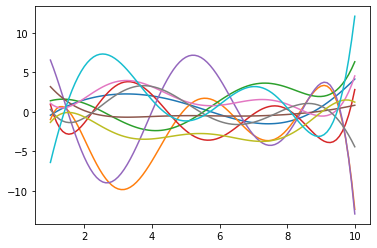

In [51]:
fig = plt.figure()
ax = plt.axes()
ax.plot(Xs,f1_samples.T)

In [53]:
inv_K_Z1Z1 = inv(  cholesky_with_jitter(K1(Z1,Z1),1e-10)@tf.transpose(cholesky_with_jitter(K1(Z1,Z1),1e-10)))

f1_sample_list = []

for i in range (0,len(Xs)):
        
    f1_sample_mean = tf.linalg.matmul(tf.linalg.matmul(K1(Xs.reshape(-1,1),Z1),inv_K_Z1Z1),m1)
    f1_sample_covariance = K1(Xs.reshape(-1,1),Xs.reshape(-1,1))-tf.linalg.matmul(tf.linalg.matmul(K1(Xs.reshape(-1,1),Z1),inv_K_Z1Z1),K1(Z1,Xs.reshape(-1,1)))+tf.linalg.matmul(tf.linalg.matmul(tf.linalg.matmul(tf.linalg.matmul(K1(Xs.reshape(-1,1),Z1),inv_K_Z1Z1),S1@tf.transpose(S1)),inv_K_Z1Z1),K1(Z1,Xs.reshape(-1,1)))
    f1_sample = tf.math.reduce_mean(tfp.distributions.Normal(f1_sample_mean,f1_sample_covariance).sample(100))
    f1_sample_list.append(f1_sample)

In [54]:
f1_sample_list = np.array(f1_sample_list).reshape(-1,1)

In [55]:
inv_K_Z2Z2 = inv(  cholesky_with_jitter(K2(Z2,Z2),1e-10)@tf.transpose(cholesky_with_jitter(K2(Z2,Z2),1e-10)))


f2_sample_mean = np.matmul(np.matmul(K2(f1_sample_list,Z2),inv_K_Z2Z2),m2)
f2_sample_covariance = K2(f1_sample_list,f1_sample_list)-np.matmul(np.matmul(K2(f1_sample_list,Z2),inv_K_Z2Z2),K2(Z2,f1_sample_list))+np.matmul(np.matmul(np.matmul(np.matmul(K2(f1_sample_list,Z2),inv_K_Z2Z2),S2@tf.transpose(S2)),inv_K_Z2Z2),K2(Z2,f1_sample_list))
f2_samples = np.random.multivariate_normal(f2_sample_mean.reshape(100,), f2_sample_covariance, 10)





/opt/anaconda3/envs/tensorflow/lib/python3.7/site-packages/ipykernel_launcher.py:6: RuntimeWarning: covariance is not positive-semidefinite.
  


In [56]:
f1_sample_list.shape

(100, 1)

In [57]:
f2_samples[0].T.shape

(100,)

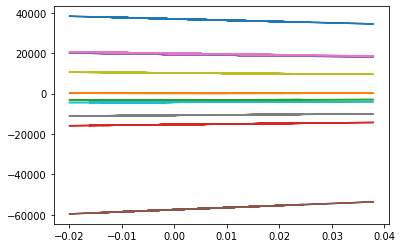

In [58]:
fig = plt.figure()
ax = plt.axes()
ax.plot(f1_sample_list,f2_samples.T)

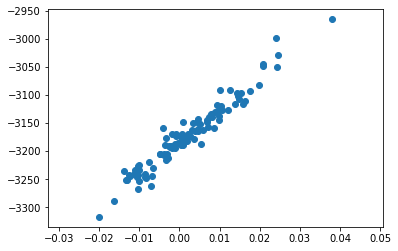

In [59]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(f1_sample_list,f2_samples[2].T)

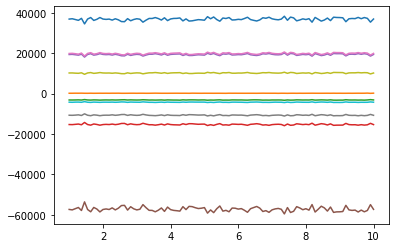

In [60]:
fig = plt.figure()
ax = plt.axes()
ax.plot(Xs,f2_samples.T)

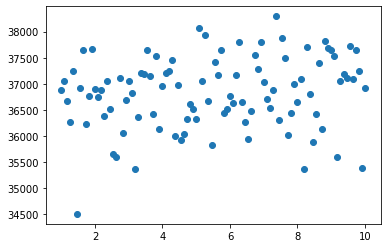

In [61]:
fig = plt.figure()
ax = plt.axes()
ax.scatter(Xs,f2_samples[0].T)